<p style="font-size: 24px; font-weight: bold;">Hello there!</p>

<p style="font-size: 16px;">This notebook introduces a super simple way to create a submission file for the competition of <b>"Parkinson's Freezing of Gait Prediction"</b>.</p>

<p style="font-size: 16px;">In this notebook, you will create features by combining 3-dimensional accelerometer data values with metadata about subjects in order to detect FoG (Freezing of Gait) events.</p>

<p style="font-size: 16px;">To predict FoG events (<code>'StartHesitation'</code>, <code>'Turn'</code>, <code>'Walking'</code>) at a given time point <code><b>t</b></code>, you will use the accelerometer data values and subject information at the same time point <code><b>t</b></code>.</p>

<p style="font-size: 16px;">However, since this procedure does not handle temporal information well, it must be necessary to conduct innovative feature engineering to achieve better performance.</p>

<p style="font-size: 16px;">The purpose of publishing this notebook is to demonstrate the rough procedure up to submitting results for the competition using simple code as much as possible.</p>

<p style="font-size: 16px;">I hope that the release of this notebook will contribute even a little to the excitement of the competition.</p>

<p style="font-size: 16px;">Let's enjoy Kaggle together!</p>

<h1>Import Modules</h1>

In [5]:
import os
import tqdm
import glob
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [6]:
# parent directory
pdir = '/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction'

# load meta data

In [7]:
df_tdcs_meta = pd.read_csv(os.path.join(pdir, 'tdcsfog_metadata.csv'))
df_tdcs_meta.head()

,Id,Subject,Visit,Test,Medication
0,003f117e14,4dc2f8,3,2,on
1,009ee11563,f62eec,4,2,on
2,011322847a,231c3b,2,2,on
3,01d0fe7266,231c3b,2,1,off
4,024418ba39,fa8764,19,3,on


In [8]:
df_defog_meta = pd.read_csv(os.path.join(pdir, 'defog_metadata.csv'))
df_defog_meta.head()

,Id,Subject,Visit,Medication
0,02ab235146,e1f62e,2,on
1,02ea782681,ae2d35,2,on
2,06414383cf,8c1f5e,2,off
3,092b4c1819,2874c5,1,off
4,0a900ed8a2,0e3d49,2,on


In [9]:
df_subjects = pd.read_csv(os.path.join(pdir, 'subjects.csv'))
df_subjects.head()

,Subject,Visit,Age,Sex,YearsSinceDx,UPDRSIII_On,UPDRSIII_Off,NFOGQ
0,00f674,2.0,63,M,27.0,43.0,49.0,24
1,00f674,1.0,63,M,27.0,31.0,30.0,26
2,02bc69,NaN,69,M,4.0,21.0,NaN,22
3,040587,2.0,75,M,26.0,52.0,69.0,21
4,040587,1.0,75,M,26.0,47.0,75.0,24


# Load tdcsfog data

In [10]:
# list of all tdcsfog csv file path
tdcs_file_path = glob.glob(os.path.join(pdir, 'train', 'tdcsfog', '*.csv'), recursive=True)

    # In this notebook, we limit the number of files to be read in order to reduce the time required for model training.

tdcs_file_path = tdcs_file_path[::10] #weghalen!!!!!!!!!!!!!

print(f'the number of files to be read: {len(tdcs_file_path)}')

pd.read_csv(tdcs_file_path[0]).head()

the number of files to be read: 84


,Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking
0,0,-9.665890,0.042550,0.184744,0,0,0
1,1,-9.672969,0.049217,0.184644,0,0,0
2,2,-9.670260,0.033620,0.193790,0,0,0
3,3,-9.673356,0.035159,0.184369,0,0,0
4,4,-9.671458,0.043913,0.197814,0,0,0


In [11]:
# Initialize a DataFrame to combine data from multiple CSV files.
df_tdcs = pd.DataFrame()

# load tdcsfog time series in combination with metadata.
for fp in tqdm.tqdm(tdcs_file_path):    
    
    # load data into a variable 'tmp'.
    tmp = pd.read_csv(fp)
    
    # get file Id from csv file name.
    file_id = os.path.basename(fp).replace(".csv", "")
    
    # get subject Id.
    subject = df_tdcs_meta.loc[df_tdcs_meta['Id'] == file_id, 'Subject'].iloc[0]
    
    # add metadata.
    tmp['Medication'] = df_tdcs_meta.loc[df_tdcs_meta['Id'] == file_id, 'Medication'].iloc[0]
    tmp['Age'] = df_subjects.loc[df_subjects['Subject'] == subject, 'Age'].iloc[0]
    tmp['Sex'] = df_subjects.loc[df_subjects['Subject'] == subject, 'Sex'].iloc[0]
    tmp['YearsSinceDx'] = df_subjects.loc[df_subjects['Subject'] == subject, 'YearsSinceDx'].iloc[0]
    tmp['NFOGQ'] =df_subjects.loc[df_subjects['Subject'] == subject, 'NFOGQ'].iloc[0]
    
    # concat the data
    df_tdcs = pd.concat([df_tdcs, tmp]).reset_index(drop=True)

100%|██████████| 84/84 [00:06<00:00, 12.57it/s]


In [12]:
# check the contents of the df_tdcs
df_tdcs.head()

,Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking,Medication,Age,Sex,YearsSinceDx,NFOGQ
0,0,-9.665890,0.042550,0.184744,0,0,0,off,66,M,9.0,13
1,1,-9.672969,0.049217,0.184644,0,0,0,off,66,M,9.0,13
2,2,-9.670260,0.033620,0.193790,0,0,0,off,66,M,9.0,13
3,3,-9.673356,0.035159,0.184369,0,0,0,off,66,M,9.0,13
4,4,-9.671458,0.043913,0.197814,0,0,0,off,66,M,9.0,13


# Load defog data

In [13]:
# list of all tdcsfog csv file path
defog_file_path = glob.glob(os.path.join(pdir, 'train', 'defog', '*.csv'), recursive=True)

# In this notebook, we limit the number of files to be read in order to reduce the time required for model training.
defog_file_path = defog_file_path[::1]

print(f'the number of files to be read: {len(defog_file_path)}')

the number of files to be read: 91


In [14]:
# Initialize a DataFrame to combine data from multiple CSV files.
df_defog = pd.DataFrame()

for fp in tqdm.tqdm(defog_file_path):
    # load data into a variable 'tmp'.
    tmp = pd.read_csv(fp)
    
    # get file Id from csv file name.
    file_id = os.path.basename(fp).replace(".csv", "")
    
    # get subject Id.
    subject = df_defog_meta.loc[df_defog_meta['Id'] == file_id, 'Subject'].iloc[0]
    
    # add metadata.
    tmp['Medication'] = df_defog_meta.loc[df_defog_meta['Id'] == file_id, 'Medication'].iloc[0]
    tmp['Age'] = df_subjects.loc[df_subjects['Subject'] == subject, 'Age'].iloc[0]
    tmp['Sex'] = df_subjects.loc[df_subjects['Subject'] == subject, 'Sex'].iloc[0]
    tmp['YearsSinceDx'] = df_subjects.loc[df_subjects['Subject'] == subject, 'YearsSinceDx'].iloc[0]
    tmp['NFOGQ'] =df_subjects.loc[df_subjects['Subject'] == subject, 'NFOGQ'].iloc[0]
    
    # extract data from the time period where Valid and Task are both True.
    tmp = tmp[(tmp['Valid'] == True) & (tmp['Task']==True)]
    tmp = tmp.drop(['Valid', 'Task'], axis=1)
    
    # concat the data
    df_defog = pd.concat([df_defog, tmp]).reset_index(drop=True)

100%|██████████| 91/91 [01:17<00:00,  1.18it/s]


In [15]:
# check the contents of the df_defog
df_defog.head()

,Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking,Medication,Age,Sex,YearsSinceDx,NFOGQ
0,1000,-1.015138,-0.071969,0.161124,0,0,0,on,72,M,16.0,18
1,1001,-1.018566,-0.057850,0.144988,0,0,0,on,72,M,16.0,18
2,1002,-1.037102,-0.054200,0.129327,0,0,0,on,72,M,16.0,18
3,1003,-1.036416,-0.060578,0.115451,0,0,0,on,72,M,16.0,18
4,1004,-1.012407,-0.069198,0.110121,0,0,0,on,72,M,16.0,18


In [16]:
import numpy as np
print("walking == 1:         ", len(np.where(df_defog['Walking']==1)[0]))
print("turn == 1:            ",len(np.where(df_defog['Turn']==1)[0]))
print("StartHesitation == 1: ",len(np.where(df_defog['StartHesitation']==1)[0]))

walking == 1:          98518
turn == 1:             586829
StartHesitation == 1:  500


# Prepare train data

In [17]:
# concat tdcs and defog data.
df_train = pd.concat([df_tdcs, df_defog]).reset_index(drop=True)
# df_train.head(100)

SH = len(np.where(df_train['StartHesitation'] == 1)[0])
W = len(np.where(df_train['Walking'] == 1)[0])
T = len(np.where(df_train['Turn'] == 1)[0])
N = len(df_train)-SH-W-T
print("No events:",N)
print("StartHesitation:",SH)
print("Walking:",W)
print("Turning:",T)

No events: 3905286
StartHesitation: 5281
Walking: 100280
Turning: 642441


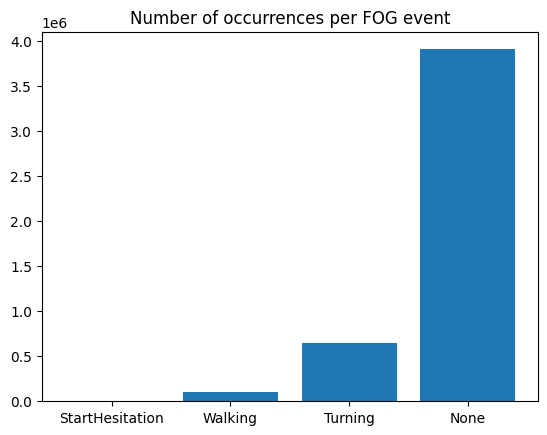

In [18]:
from matplotlib import pyplot as plt
plt.bar(["StartHesitation", "Walking", "Turning", "None"], [SH,W,T,N])
plt.title("Number of occurrences per FOG event")
plt.show()

In [19]:
# encode string columns into 0/1 format
df_train['Medication'] = np.where(df_train['Medication']=='on', 1, 0)
df_train['Sex'] = np.where(df_train['Sex']=='M', 1, 0)
df_train.head()

,Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking,Medication,Age,Sex,YearsSinceDx,NFOGQ
0,0,-9.665890,0.042550,0.184744,0,0,0,0,66,1,9.0,13
1,1,-9.672969,0.049217,0.184644,0,0,0,0,66,1,9.0,13
2,2,-9.670260,0.033620,0.193790,0,0,0,0,66,1,9.0,13
3,3,-9.673356,0.035159,0.184369,0,0,0,0,66,1,9.0,13
4,4,-9.671458,0.043913,0.197814,0,0,0,0,66,1,9.0,13


# Split train data for 3 classes

In [20]:
df_train_turn = df_train[df_train['Turn'] == 1]
df_train_walking = df_train[df_train['Walking'] == 1]
df_train_start = df_train[df_train['StartHesitation'] == 1]
df_train_none = df_train[np.where(df_train['Turn']==0, df_train['Walking']==0, df_train['StartHesitation']==0)]
df_train_turn_y = pd.DataFrame(np.zeros(len(df_train_turn)))
df_train_none_y = pd.DataFrame(np.ones(len(df_train_none)))


In [21]:
df_train_walk_y = pd.DataFrame(np.full(len(df_train_walking), 2))
df_train_start_y = pd.DataFrame(np.full(len(df_train_start), 3))

In [22]:
df_train_turn_none_undersampling_X = pd.concat([df_train_turn, df_train_none])
df_train_turn_none_undersampling_y = pd.concat([df_train_turn_y, df_train_none_y])

In [ ]:
# # split data into features and target.
# y_turn = df_train['Turn']                       # target
# X_turn = df_train.drop(['StartHesitation', 'Turn', 'Walking', 'Time'], axis=1)  # feature

# y_walking = df_train['Walking']                       # target
# X_walking = df_train.drop(['StartHesitation', 'Turn', 'Walking', 'Time'], axis=1)  # feature

# y_start = df_train['StartHesitation']                       # target
# X_start = df_train.drop(['StartHesitation', 'Turn', 'Walking', 'Time'], axis=1)  # feature

In [ ]:
# df_train['label'] = np.where(df_train['Turn'] == 1, 1,
#                     np.where(df_train['Walking'] == 1, 2,
#                     np.where(df_train['StartHesitation'] == 1, 3, 0)))

# df_train_sampling
# print(np.where(df_train['Turn'] + df_train['Walking'] + df_train['StartHesitation'] >1))

In [ ]:
# X_data = df_train.drop(['StartHesitation', 'Turn', 'Walking', 'Time', 'label'], axis=1)  # feature
# y_data = df_train['label']

# Undersampling majority class

In [23]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0, sampling_strategy='not minority')
X_data_undersampled, y_data_undersampled = rus.fit_resample(df_train_turn_none_undersampling_X, df_train_turn_none_undersampling_y)
print(len(X_data_undersampled))
print(len(y_data_undersampled))

1284882
1284882


In [24]:
print(type(X_data_undersampled))

<class 'pandas.core.frame.DataFrame'>


# SMOTE

Undersampled is alle 4 classes samen waarvan none undersampled is van 8m naar 2m (size van turn). Hierdoor worden alle classes met smote 2m.

In [25]:
X_undersampled = pd.concat([X_data_undersampled, df_train_walking, df_train_start])
y_undersampled = pd.concat([y_data_undersampled, df_train_walk_y, df_train_start_y])

In [27]:
smote = SMOTE(random_state = 4, k_neighbors=100)
X_syn, y_syn = smote.fit_resample(X_undersampled, y_undersampled)

In [28]:
print(len(np.where(y_syn == 0)[0]))
print(len(np.where(y_syn == 1)[0]))
print(len(np.where(y_syn == 2)[0]))
print(len(np.where(y_syn == 3)[0]))

642441
642441
642441
642441


In [ ]:
del df_train, y_undersampled,X_undersampled, X_data_undersampled, y_data_undersampled, df_train_walk_y, df_train_start_y, df_train_turn, df_train_walking, df_train_start, df_train_none, df_train_turn_y,df_train_none_y, df_train_turn_none_undersampling_X, df_train_turn_none_undersampling_y, SH, W, T,N

In [29]:
X_syn.head()

,Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking,Medication,Age,Sex,YearsSinceDx,NFOGQ
0,1750,-9.225695,0.149824,0.548065,0,1,0,0,66,1,9.0,13
1,1751,-9.313448,0.078304,0.780449,0,1,0,0,66,1,9.0,13
2,1752,-9.540124,-0.010619,1.026785,0,1,0,0,66,1,9.0,13
3,1753,-9.769265,-0.031165,1.149211,0,1,0,0,66,1,9.0,13
4,1754,-9.985678,-0.061772,1.178558,0,1,0,0,66,1,9.0,13


In [30]:
X_syn_fixed = X_syn.drop(["StartHesitation", "Turn", "Walking"], axis=1)

In [31]:
X_syn_fixed.head()

,Time,AccV,AccML,AccAP,Medication,Age,Sex,YearsSinceDx,NFOGQ
0,1750,-9.225695,0.149824,0.548065,0,66,1,9.0,13
1,1751,-9.313448,0.078304,0.780449,0,66,1,9.0,13
2,1752,-9.540124,-0.010619,1.026785,0,66,1,9.0,13
3,1753,-9.769265,-0.031165,1.149211,0,66,1,9.0,13
4,1754,-9.985678,-0.061772,1.178558,0,66,1,9.0,13


In [34]:
y_syn = np.array(y_syn)  # Convert y_syn to NumPy array

labels = y_syn.flatten().astype(int)  # Flatten and convert to int

zeros_array = np.zeros(len(labels), dtype=int)

# Create arrays for each column using vectorized operations
start_hesitation = np.where(labels == 3, 1, zeros_array)
turn = np.where(labels == 0, 1, zeros_array)
walking = np.where(labels == 2, 1, zeros_array)

# Create the DataFrame using the NumPy arrays
y_syn_fixed = pd.DataFrame({
    "StartHesitation": start_hesitation,
    "Turn": turn,
    "Walking": walking
})

y_syn_fixed.head()

,StartHesitation,Turn,Walking
0,0,1,0
1,0,1,0
2,0,1,0
3,0,1,0
4,0,1,0


# Random Search CV

In [35]:
import numpy as np
#### Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 1, stop = 40, num = 1)]

# Number of features to consider at every split
# max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(start = 3, stop = 9, num = 1)]

# Minimum number of samples required to split a node
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 20, num = 1)]

# Minimum number of samples required at each leaf node
min_samples_leaf = [int(x) for x in np.linspace(start = 1, stop = 10, num = 1)]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# # Whether to use out-of-bag samples to estimate the generalization score. Only available if bootstrap=True.
# oob_score = [True, False]

#Class weight 
# class_weight = #hier een dictionary maken met de weight distributions 

#

In [36]:
# Create the param grid
param_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
             }
               #'class_weight': class_weight}
print(param_grid)

{'n_estimators': [1], 'max_depth': [3], 'min_samples_split': [2], 'min_samples_leaf': [1], 'bootstrap': [True, False]}


# Train RandomForestClassifier

In [108]:
# train the model with default parameter
rfSH = RandomForestClassifier(random_state=0, n_estimators=10, n_jobs=-1, class_weight=[{0:1,1:1}])
rfW = RandomForestClassifier(random_state=0, n_estimators=10, n_jobs=-1, class_weight=[{0:1,1:1}])
rfT = RandomForestClassifier(random_state=0, n_estimators=10, n_jobs=-1, class_weight=[{0:1,1:1}])

from sklearn.model_selection import GridSearchCV
rfSH_Grid = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 10, verbose=2, n_jobs = -1, return_train_score=True)
rfW_Grid = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 10, verbose=2, n_jobs = -1, return_train_score=True)
rfT_Grid = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 10, verbose=2, n_jobs = -1, return_train_score=True)


rfSH_Grid.fit(X_syn_fixed, y_syn_fixed['StartHesitation'])
rfW_Grid.fit(X_syn_fixed, y_syn_fixed['Walking'])
rfT_Grid.fit(X_syn_fixed, y_syn_fixed['Turn'])

Fitting 10 folds for each of 10 candidates, totalling 100 fits


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


KeyboardInterrupt: 

In [62]:
print("Grid search results:")
print(rfSH_Grid.cv_results_.keys())
print(rfW_Grid.cv_results_.keys())
print(rfT_Grid.cv_results_.keys())

[array([0, 1]), array([0, 1]), array([0, 1])]
[2, 2, 2]


# Prepare test data

## Process the test data in the same way as the training data

In [63]:
# list of all tdcsfog csv file path
tdcs_test_file_path = glob.glob(os.path.join(pdir, 'test', 'tdcsfog', '*.csv'), recursive=True)
print(f'the number of files to be read: {len(tdcs_test_file_path)}')

the number of files to be read: 1


In [65]:
# Initialize a DataFrame to combine data from multiple CSV files.
df_tdcs_test = pd.DataFrame()

for fp in tqdm.tqdm(tdcs_test_file_path):
    
    # load data into a variable 'tmp'.
    tmp = pd.read_csv(fp)
    
    # get file Id from csv file name.
    file_id = os.path.basename(fp).replace(".csv", "")
    
    # get subject Id.
    subject = df_tdcs_meta.loc[df_tdcs_meta['Id'] == file_id, 'Subject'].iloc[0]
    
    # add metadata.
    tmp['Medication'] = df_tdcs_meta.loc[df_tdcs_meta['Id'] == file_id, 'Medication'].iloc[0]
    tmp['Age'] = df_subjects.loc[df_subjects['Subject'] == subject, 'Age'].iloc[0]
    tmp['Sex'] = df_subjects.loc[df_subjects['Subject'] == subject, 'Sex'].iloc[0]
    tmp['YearsSinceDx'] = df_subjects.loc[df_subjects['Subject'] == subject, 'YearsSinceDx'].iloc[0]
    tmp['NFOGQ'] =df_subjects.loc[df_subjects['Subject'] == subject, 'NFOGQ'].iloc[0]
    
    # add Id data to submit.
    tmp['Id'] = file_id + '_' + tmp['Time'].astype(str)
    
    # concat the data
    df_tdcs_test = pd.concat([df_tdcs_test, tmp]).reset_index(drop=True)
print(df_tdcs_test[0:4])

100%|██████████| 1/1 [00:00<00:00, 49.99it/s]

   Time      AccV     AccML     AccAP Medication  Age Sex  YearsSinceDx  \
0     0 -9.533939  0.566322 -1.413525         on   68   F           9.0   
1     1 -9.536140  0.564137 -1.440621         on   68   F           9.0   
2     2 -9.529345  0.561765 -1.429332         on   68   F           9.0   
3     3 -9.531239  0.564227 -1.415490         on   68   F           9.0   

   NFOGQ            Id  
0     15  003f117e14_0  
1     15  003f117e14_1  
2     15  003f117e14_2  
3     15  003f117e14_3  


In [66]:
# check the contents of the df_tdcs_test
df_tdcs_test.head()

,Time,AccV,AccML,AccAP,Medication,Age,Sex,YearsSinceDx,NFOGQ,Id
0,0,-9.533939,0.566322,-1.413525,on,68,F,9.0,15,003f117e14_0
1,1,-9.536140,0.564137,-1.440621,on,68,F,9.0,15,003f117e14_1
2,2,-9.529345,0.561765,-1.429332,on,68,F,9.0,15,003f117e14_2
3,3,-9.531239,0.564227,-1.415490,on,68,F,9.0,15,003f117e14_3
4,4,-9.540825,0.561854,-1.429471,on,68,F,9.0,15,003f117e14_4


In [67]:
# list of all tdcsfog csv file path
defog_test_file_path = glob.glob(os.path.join(pdir, 'test', 'defog', '*.csv'), recursive=True)
print(f'the number of files to be read: {len(defog_test_file_path)}')

the number of files to be read: 1


In [68]:
# Initialize a DataFrame to combine data from multiple CSV files.
df_defog_test = pd.DataFrame()

for fp in tqdm.tqdm(defog_test_file_path):
    # load data into a variable 'tmp'.
    tmp = pd.read_csv(fp)
    
    # get file Id from csv file name.
    file_id = os.path.basename(fp).replace(".csv", "")
    
    # get subject Id.
    subject = df_defog_meta.loc[df_defog_meta['Id'] == file_id, 'Subject'].iloc[0]
    
    # add metadata.
    tmp['Medication'] = df_defog_meta.loc[df_defog_meta['Id'] == file_id, 'Medication'].iloc[0]
    tmp['Age'] = df_subjects.loc[df_subjects['Subject'] == subject, 'Age'].iloc[0]
    tmp['Sex'] = df_subjects.loc[df_subjects['Subject'] == subject, 'Sex'].iloc[0]
    tmp['YearsSinceDx'] = df_subjects.loc[df_subjects['Subject'] == subject, 'YearsSinceDx'].iloc[0]
    tmp['NFOGQ'] =df_subjects.loc[df_subjects['Subject'] == subject, 'NFOGQ'].iloc[0]
    
    # add Id data to submit.
    tmp['Id'] = file_id + '_' + tmp['Time'].astype(str)
    
    # concat the data
    df_defog_test = pd.concat([df_defog_test, tmp]).reset_index(drop=True)

100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


In [69]:
# check the contents of the df_defog_test
df_defog_test.head()

,Time,AccV,AccML,AccAP,Medication,Age,Sex,YearsSinceDx,NFOGQ,Id
0,0,-0.914652,-0.300851,0.298156,on,79,F,8.0,28,02ab235146_0
1,1,-0.914367,-0.301572,0.298325,on,79,F,8.0,28,02ab235146_1
2,2,-0.779540,-0.343197,0.275690,on,79,F,8.0,28,02ab235146_2
3,3,-0.993162,-0.270281,0.315775,on,79,F,8.0,28,02ab235146_3
4,4,-0.948767,-0.307849,0.297191,on,79,F,8.0,28,02ab235146_4


In [70]:
# concat tdcs and defog data.
df_test = pd.concat([df_tdcs_test, df_defog_test]).reset_index(drop=True)

# encode string columns into 0/1 format
df_test['Medication'] = np.where(df_test['Medication']=='on', 1, 0)
df_test['Sex'] = np.where(df_test['Sex']=='M', 1, 0)
display(df_test)

,Time,AccV,AccML,AccAP,Medication,Age,Sex,YearsSinceDx,NFOGQ,Id
0,0,-9.533939,0.566322,-1.413525,1,68,0,9.0,15,003f117e14_0
1,1,-9.536140,0.564137,-1.440621,1,68,0,9.0,15,003f117e14_1
2,2,-9.529345,0.561765,-1.429332,1,68,0,9.0,15,003f117e14_2
3,3,-9.531239,0.564227,-1.415490,1,68,0,9.0,15,003f117e14_3
4,4,-9.540825,0.561854,-1.429471,1,68,0,9.0,15,003f117e14_4
...,...,...,...,...,...,...,...,...,...,...
286365,281683,-0.899299,-0.232668,0.389147,1,79,0,8.0,28,02ab235146_281683
286366,281684,-0.901973,-0.233051,0.390114,1,79,0,8.0,28,02ab235146_281684
286367,281685,-0.901690,-0.231888,0.391896,1,79,0,8.0,28,02ab235146_281685
286368,281686,-0.899576,-0.232429,0.391106,1,79,0,8.0,28,02ab235146_281686


In [71]:
# split data into submission Id and feature.
Id = df_test['Id']                             # Id for submission data
# X_test = df_test.drop(['Time', 'Id'], axis=1)  # feature of test data
# X_test.head()
X_test = df_test.drop(['Id'], axis=1)
X_test.head()

,Time,AccV,AccML,AccAP,Medication,Age,Sex,YearsSinceDx,NFOGQ
0,0,-9.533939,0.566322,-1.413525,1,68,0,9.0,15
1,1,-9.536140,0.564137,-1.440621,1,68,0,9.0,15
2,2,-9.529345,0.561765,-1.429332,1,68,0,9.0,15
3,3,-9.531239,0.564227,-1.415490,1,68,0,9.0,15
4,4,-9.540825,0.561854,-1.429471,1,68,0,9.0,15


# Predict and submit

In [72]:
# calculate prediction using trained RandomForestClassifier model.
predictionSH = rfSH_Grid.predict_proba(X_test)
predictionW = rfW_Grid.predict_proba(X_test)
predictionT = rfT_Grid.predict_proba(X_test)

In [99]:
# print(prediction[0][888][0])
# print(prediction[1][888][0])
# print(prediction[2][888][0])

SHprediction = predictionSH
Wprediction = predictionW
Tprediction =predictionT
print("Start hesitation predictions:")
print(SHprediction)
print("Walking predictions:")
print(Wprediction)
print("Turn predictions:")
print(Tprediction)

In [100]:
# Prepare submit data
# submit = pd.DataFrame(Id, columns=['Id'])
# submit['StartHesitation'] = SHprediction[:, 0]
# submit['Turn'] = Tprediction[:, 0]
# submit['Walking'] = Wprediction[:, 0]

In [101]:
# display(submit)

,Id,StartHesitation,Turn,Walking
0,003f117e14_0,1.0,1.000000,1.0
1,003f117e14_1,1.0,1.000000,1.0
2,003f117e14_2,1.0,1.000000,1.0
3,003f117e14_3,1.0,1.000000,1.0
4,003f117e14_4,1.0,1.000000,1.0
...,...,...,...,...
286365,02ab235146_281683,1.0,0.966667,1.0
286366,02ab235146_281684,1.0,0.966667,1.0
286367,02ab235146_281685,1.0,0.966667,1.0
286368,02ab235146_281686,1.0,0.966667,1.0


In [ ]:
## Save the created submission data.
# submit.to_csv('submission.csv', index=False)

In [ ]:
# submit

<p style="font-size: 24px; font-weight: bold;">Congratulations!</p>

<p style="font-size: 16px;">You're now ready to submit your work on Kaggle!</p>

<p style="font-size: 16px;">Enjoy your experience on Kaggle!</p>